In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

In [4]:
df = pd.read_csv('../data/Expanded_data_with_more_features.csv')
df = df.drop(columns=['Unnamed: 0'])

In [5]:
# Check if cuda is available
device = torch.device('cpu')

In [6]:
# Setting categorical features as numbers and removing NaN's by calculating mean value 
for column in df.columns:
    df[column] = df[column].astype('category').cat.codes
    df[column] = df[column].fillna(df[column].mean())

Text(0.5, 1.0, 'Korelacja między zmiennymi')

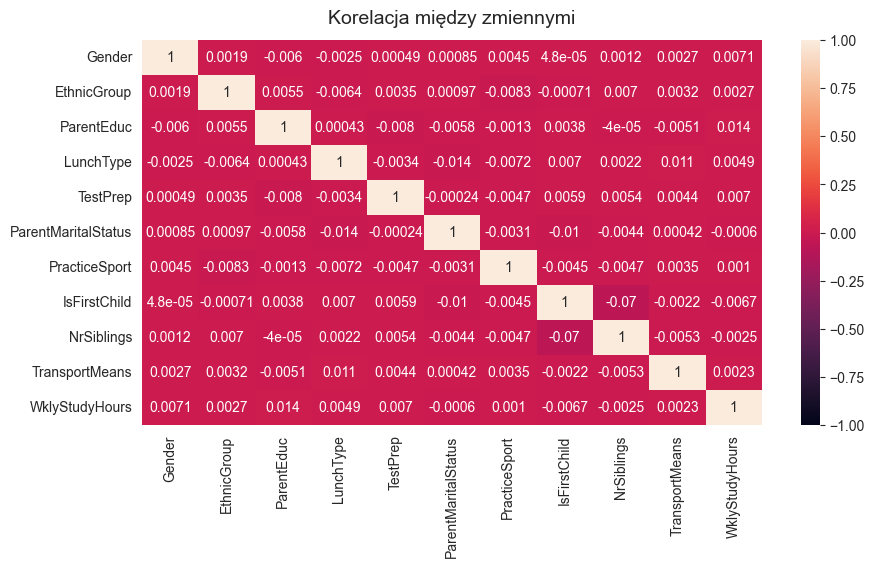

In [7]:
correlation_matrix = df.drop(['WritingScore', 'MathScore', 'ReadingScore'], axis=1).corr()
plt.figure(figsize=(10, 5))
heatmap = sns.heatmap(correlation_matrix, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Korelacja między zmiennymi', fontdict={'fontsize': 14}, pad=12)

In [8]:
num_rows = len(df)
num_rows

30641

In [9]:
input_columns = list(df.drop(['WritingScore', 'MathScore', 'ReadingScore'], axis=1).columns)
input_columns

['Gender',
 'EthnicGroup',
 'ParentEduc',
 'LunchType',
 'TestPrep',
 'ParentMaritalStatus',
 'PracticeSport',
 'IsFirstChild',
 'NrSiblings',
 'TransportMeans',
 'WklyStudyHours']

In [10]:
output_columns = df.columns[-1]
output_columns

'WritingScore'

In [11]:
def dataframe_to_arrays(dataframe: pd.DataFrame) -> list[np.ndarray]:
    # Make a copy of original df
    df1 = dataframe.copy(deep=True)
    # Extract input & outputs as numpy arrays
    input_array = df1.drop(['WritingScore', 'MathScore', 'ReadingScore'], axis=1).values
    target_array = df1[['MathScore']].values
    return [input_array, target_array]

In [12]:
inputs_array = dataframe_to_arrays(df)[0]
targets_array = dataframe_to_arrays(df)[1]

In [13]:
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(pd.read_csv('../data/Expanded_data_with_more_features.csv'))
joblib.dump(vectorizer, '../data/vectorizer.pkl')

['../data/vectorizer.pkl']

In [14]:
inputs = torch.from_numpy(inputs_array).to(torch.float32)
targets = torch.from_numpy(targets_array).to(torch.float32)

In [15]:
dataset = TensorDataset(inputs, targets)

In [16]:
val_percent = 0.20
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size

# use the random_split function to split dataset into 2 parts of the desired length
train_ds, val_ds = random_split(dataset, [train_size, val_size])

In [17]:
batch_size = 32

In [18]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

In [19]:
input_size = len(input_columns)
hidden_size = int(input_size / 2)
hidden_size2 = int(hidden_size / 2)
output_size = 1

In [20]:
class MathScoreModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(MathScoreModel, self).__init__()
        self.linear1 = nn.Linear(input_size, 8)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(8, output_size)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.linear2(x)
        return x

    def training_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs.to(device))
        # Calculate loss
        loss = F.l1_loss(out.to(device), targets.to(device))
        return loss

    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs.to(device))
        # Calculate loss
        loss = F.l1_loss(out.to(device), targets.to(device))
        return {'val_loss': loss.detach()}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        # Combine losses
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result, num_epochs):
        # Print result after 20th epoch
        if (epoch + 1) % 500 == 0 or epoch == num_epochs - 1:
            print(f'Epoch {epoch + 1}, val_loss {result["val_loss"]}')

In [21]:
model = MathScoreModel(input_size, output_size).to(device)

C:\Users\Aleks\Documents\projects\PJATK\SUML_Projekt_GR1\.venv\Lib\site-packages\torch_lr_finder\lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/25 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 6.81E-05


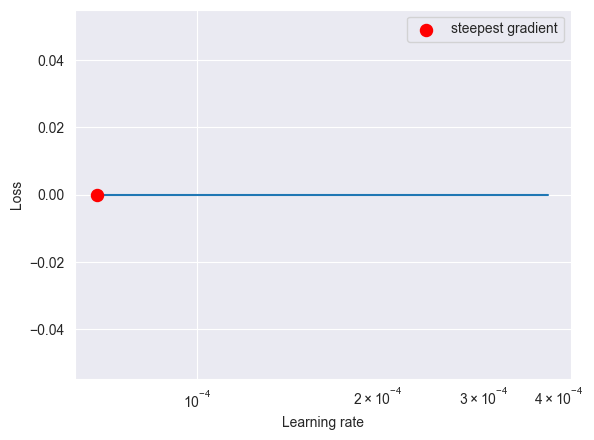

In [22]:
from torch_lr_finder import LRFinder
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.00001)
lr_finder = LRFinder(model, optimizer, criterion, device) 
lr_finder.range_test(train_loader, end_lr = 0.001, num_iter = 25)
lr_finder.plot()
lr_finder.reset()

In [23]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=optim.SGD) -> list:
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

In [24]:
result = evaluate(model, val_loader)
print(result)

{'val_loss': 60.66628646850586}


In [25]:
epochs = 2000
lr = 6.81E-05
history = fit(epochs, lr, model, train_loader, val_loader)

Epoch 500, val_loss 11.089035034179688
Epoch 1000, val_loss 11.013218879699707
Epoch 1500, val_loss 10.969622611999512
Epoch 2000, val_loss 10.957579612731934


In [26]:
val_loss = history[-1]
val_loss

{'val_loss': 10.957579612731934}

In [27]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs.to(device))
    prediction = predictions[0].detach()
    print(f'Input: {input}')
    print(f'Target: {target}')
    print(f'Prediction: {prediction}')

In [28]:
input, target = val_ds[5]
print(type(val_ds))
predict_single(input, target, model)

<class 'torch.utils.data.dataset.Subset'>
Input: tensor([1., 3., 5., 0., 1., 0., 1., 1., 2., 0., 1.])
Target: tensor([48.])
Prediction: tensor([54.5983])


In [29]:
input, target = val_ds[10]
predict_single(input, target, model)

Input: tensor([ 0.,  3., -1.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.])
Target: tensor([66.])
Prediction: tensor([70.0456])


In [30]:
input,target = val_ds[13]
predict_single(input, target, model)

Input: tensor([0., 1., 1., 0., 1., 1., 2., 1., 2., 0., 1.])
Target: tensor([35.])
Prediction: tensor([47.3426])


In [31]:
input,target = val_ds[54]
predict_single(input, target, model)

Input: tensor([0., 0., 4., 1., 1., 1., 0., 1., 2., 1., 1.])
Target: tensor([52.])
Prediction: tensor([56.6989])


In [44]:
input,target = val_ds[87]
predict_single(input, target, model)

Input: tensor([1., 2., 3., 0., 0., 0., 2., 0., 4., 0., 1.])
Target: tensor([47.])
Prediction: tensor([55.3997])


In [66]:
torch.save(model.state_dict(), '../models/math_score_model_state.pt')

In [47]:
print(val_ds[87])
print(type(val_ds[87]))

(tensor([1., 2., 3., 0., 0., 0., 2., 0., 4., 0., 1.]), tensor([47.]))
<class 'tuple'>


In [48]:
model_input = torch.tensor([1., 2., 5., 0., 1., 2., 0., 1., 1., 1., 0.], dtype=torch.float32)

In [49]:
output = model(model_input)
float(output[0])

49.24230194091797